# Text Classification with Scikit-Learn

This lab applies a full text classification workflow on the 20 Newsgroups dataset using scikit-learn.


## Objectives
- Load and inspect the 20 Newsgroups dataset.
- Clean the raw text with lowercasing, punctuation removal, stopword filtering, stemming, and lemmatization.
- Compare CountVectorizer and TfidfVectorizer feature sets along with multiple classifiers.
- Evaluate models with accuracy, precision, recall, F1, and a confusion matrix.
- Explore dimensionality reduction and hyperparameter tuning, then highlight insights from misclassified samples.


## Setup
The imports below cover text processing, model building, evaluation, and visualization.


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import certifi
import ssl
import urllib.request
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

np.random.seed(42)
sns.set_theme(style="whitegrid")

ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(
    urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context))
)


In [42]:
downloads = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']
for resource in downloads:
    nltk.download(resource, quiet=True)


## Load the dataset
The 20 Newsgroups corpus contains posts from 20 topics. Headers, footers, and quotes are removed to focus on body text.


In [43]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
targets = newsgroups.target
target_names = newsgroups.target_names

print(f'Total documents: {len(texts)} across {len(target_names)} topics.')


Total documents: 18846 across 20 topics.


In [44]:
label_series = pd.Series([target_names[idx] for idx in targets])
label_counts = label_series.value_counts().sort_values(ascending=False)
label_counts.head(10)


rec.sport.hockey           999
soc.religion.christian     997
rec.motorcycles            996
rec.sport.baseball         994
sci.crypt                  991
rec.autos                  990
sci.med                    990
comp.windows.x             988
sci.space                  987
comp.os.ms-windows.misc    985
Name: count, dtype: int64

In [45]:
sample_indices = np.random.choice(len(texts), size=3, replace=False)
for idx in sample_indices:
    print('-' * 80)
    print(f'Label: {target_names[targets[idx]]}')
    print(texts[idx][:500].strip())


--------------------------------------------------------------------------------
Label: rec.sport.baseball
The runner can leave his base at any time.  If the ball is caught,
he's got to tag up.  If it isn't caught, he _doesn't_ have to tag up at
all.  So, if he's feeling lucky, your runner at second can sprint for glory
as soon as the ball is popped up.  If it isn't caught, he's probably scored
a run.  If it is, he's probably headed for AAA.  

	The only effect the infield fly has is to make the batter out,
thereby removing the force on the runners on base.  All other rules apply,
as if you were
--------------------------------------------------------------------------------
Label: sci.electronics
Well, it's not an FTP site, but I got an 800 number for Signetics BBS.

The Signetics BBS contain some pretty good items for the 8051.  I am
currently using the following files which I downloaded from them:

    ml-asm51.zip      MetaLink's 8051 family macro assembler
    bootstrp.zip      He

## Text preprocessing
The cleaning pipeline lowercases text, removes punctuation, filters stopwords, lemmatizes, and stems tokens. Combining lemmatization and stemming keeps core meanings while normalizing variants.


In [46]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
punct_pattern = re.compile(r"[^a-zA-Z\s]")

def preprocess_text(text: str) -> str:
    # Normalize text through token cleanup, lemmatization, and stemming.
    text = text.lower()
    text = punct_pattern.sub(' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)


In [47]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    texts, targets, test_size=0.2, random_state=42, stratify=targets
)

print(f'Train size: {len(X_train_raw)}, Test size: {len(X_test_raw)}')


Train size: 15076, Test size: 3770


In [48]:
%%time
X_train = [preprocess_text(doc) for doc in X_train_raw]
X_test = [preprocess_text(doc) for doc in X_test_raw]


CPU times: user 16.1 s, sys: 103 ms, total: 16.2 s
Wall time: 16.4 s


In [49]:
idx = np.random.randint(0, len(X_train))
print('Original sample:\n', X_train_raw[idx][:250].strip())
print('\nCleaned sample:\n', X_train[idx][:250].strip())


Original sample:
 Hi,

I got a NE2100 compatible ethernet card, and I just received my copy
of Chameleon NFS. Unfortunately, it is not compatible with the NE2100
(only NE2000 or NE1000). What is the latest version number for Chameleon
NFS ? Did soemone tackle this pro

Cleaned sample:
 hi got ne compat ethernet card receiv copi chameleon nf unfortun compat ne ne ne latest version number chameleon nf soemon tackl problem thank help f popineau


## Feature extraction and model training
We compare multiple vectorizers (with and without bigrams) and classifiers. Metrics use weighted averages to account for class imbalance.


In [50]:
vectorizers = {
    'Count (1,1)': CountVectorizer(max_features=20000, ngram_range=(1, 1)),
    'Count (1,2)': CountVectorizer(max_features=20000, ngram_range=(1, 2)),
    'TF-IDF (1,1)': TfidfVectorizer(max_features=20000, ngram_range=(1, 1)),
    'TF-IDF (1,2)': TfidfVectorizer(max_features=20000, ngram_range=(1, 2)),
}

classifiers = {
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC(max_iter=5000),
    'Logistic Regression': LogisticRegression(
        max_iter=5000,
        solver='saga',
        penalty='l2',
        multi_class='multinomial',
        random_state=42,
    ),
}


In [51]:
results = []
best_model = None
best_accuracy = 0.0

for vec_name, vec in vectorizers.items():
    fitted_vec = clone(vec)
    X_train_vec = fitted_vec.fit_transform(X_train)
    X_test_vec = fitted_vec.transform(X_test)
    for clf_name, clf in classifiers.items():
        model = clone(clf)
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        results.append({
            'Vectorizer': vec_name,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        })
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = {
                'vectorizer_name': vec_name,
                'vectorizer': fitted_vec,
                'classifier_name': clf_name,
                'classifier': model,
                'y_pred': y_pred
            }

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_

,Vectorizer,Classifier,Accuracy,Precision,Recall,F1
0,"TF-IDF (1,1)",Linear SVC,0.752785,0.760636,0.752785,0.753137
1,"TF-IDF (1,2)",Linear SVC,0.749337,0.756849,0.749337,0.749702
2,"TF-IDF (1,2)",Logistic Regression,0.743501,0.753538,0.743501,0.742129
3,"TF-IDF (1,1)",Logistic Regression,0.742175,0.749423,0.742175,0.741153
4,"TF-IDF (1,1)",Multinomial NB,0.724934,0.768751,0.724934,0.713978
5,"TF-IDF (1,2)",Multinomial NB,0.719098,0.753319,0.719098,0.709011
6,"Count (1,1)",Multinomial NB,0.696817,0.696119,0.696817,0.679403
7,"Count (1,2)",Multinomial NB,0.686472,0.694698,0.686472,0.669026
8,"Count (1,1)",Linear SVC,0.654907,0.662533,0.654907,0.656220
9,"Count (1,2)",Linear SVC,0.654111,0.659953,0.654111,0.654864


/var/folders/5h/x_c6rtfj0fqg1j_01tgdybxh0000gn/T/ipykernel_6220/4179396629.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_display, x='Accuracy', y='Model', palette='viridis')


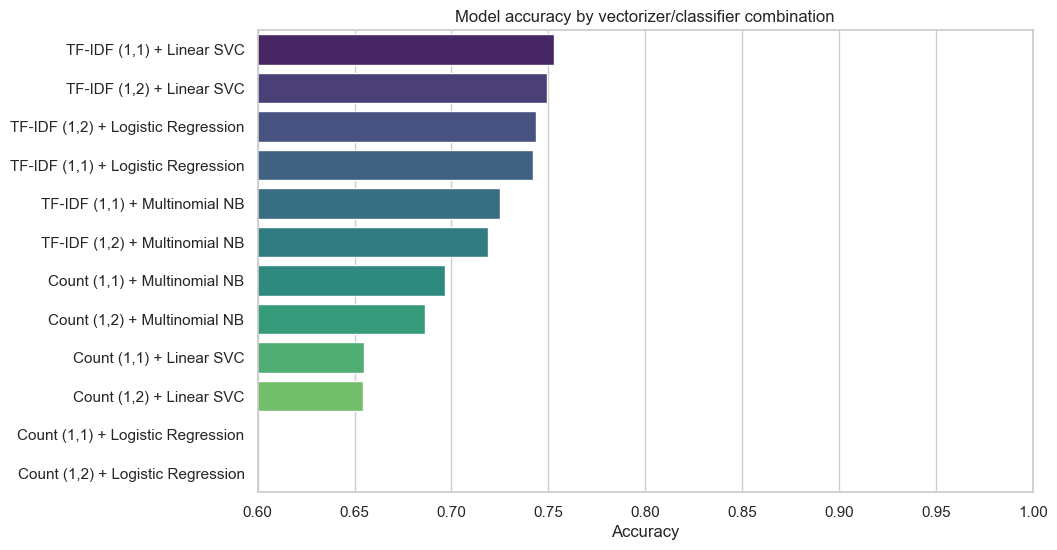

In [52]:
results_display = results_df.copy()
results_display['Model'] = results_display['Vectorizer'] + ' + ' + results_display['Classifier']
plt.figure(figsize=(10, 6))
sns.barplot(data=results_display, x='Accuracy', y='Model', palette='viridis')
plt.title('Model accuracy by vectorizer/classifier combination')
plt.xlabel('Accuracy')
plt.ylabel('')
plt.xlim(0.6, 1.0)
plt.show()


In [53]:
print(f"Best model: {best_model['vectorizer_name']} + {best_model['classifier_name']}")
print(classification_report(y_test, best_model['y_pred'], target_names=target_names))


Best model: TF-IDF (1,1) + Linear SVC
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.56      0.63       160
           comp.graphics       0.72      0.75      0.73       195
 comp.os.ms-windows.misc       0.69      0.70      0.70       197
comp.sys.ibm.pc.hardware       0.64      0.67      0.66       196
   comp.sys.mac.hardware       0.76      0.72      0.74       193
          comp.windows.x       0.82      0.83      0.83       198
            misc.forsale       0.75      0.70      0.72       195
               rec.autos       0.52      0.82      0.63       198
         rec.motorcycles       0.80      0.73      0.76       199
      rec.sport.baseball       0.89      0.84      0.87       199
        rec.sport.hockey       0.92      0.89      0.90       200
               sci.crypt       0.85      0.83      0.84       198
         sci.electronics       0.75      0.73      0.74       197
                 sci.med       0.84  

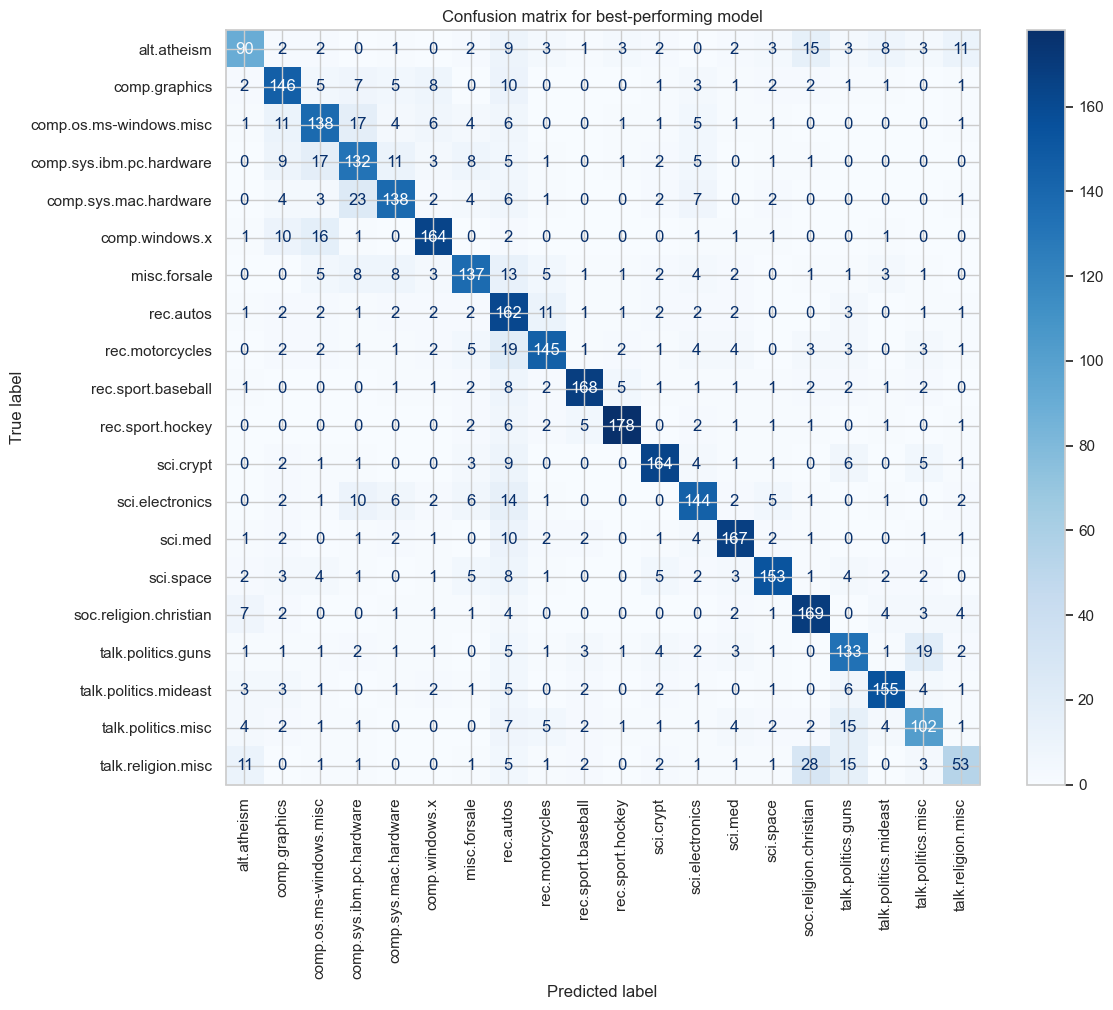

In [54]:
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, best_model['y_pred'], display_labels=target_names, cmap='Blues', ax=ax
)
plt.xticks(rotation=90)
plt.title('Confusion matrix for best-performing model')
plt.tight_layout()
plt.show()


In [55]:
misclassified_indices = np.where(best_model['y_pred'] != y_test)[0]
rng = np.random.default_rng(42)
inspect_count = min(5, len(misclassified_indices))
for idx in rng.choice(misclassified_indices, size=inspect_count, replace=False):
    print('-' * 80)
    print(f"True label: {target_names[y_test[idx]]}")
    print(f"Predicted label: {target_names[best_model['y_pred'][idx]]}")
    print('Snippet:', X_test_raw[idx][:400].strip())


--------------------------------------------------------------------------------
True label: talk.religion.misc
Predicted label: alt.atheism
Snippet: Unless God admits that he didn't do it....

	=)


---  

  " I'd Cheat on Hillary Too."
--------------------------------------------------------------------------------
True label: rec.sport.hockey
Predicted label: rec.sport.baseball
Snippet: That's true, but according to your stats, Chicago has just as good a
record as Toronto.  It's interesting that you should list Toronto ahead
of Chicago.
--------------------------------------------------------------------------------
True label: sci.crypt
Predicted label: sci.electronics
Snippet: [..stuff deleted]

I can buy a DES keysearch machine off the shelf now for approx $500K, but
it is not sold by that name. Go buy a circuit emulation machine (eg. Quickturn)
containing a bunch of FPGAs, (say 500 to 1000 3090's), and program each
to be a DES search engine. Lets say 500 chips, running at 10Mhz 

### Misclassification Insights
Most errors occur between closely related computer technology and science categories where articles share overlapping terminology. Adding subject-specific features or incorporating bi-/tri-grams could further separate these edge cases.

## Dimensionality reduction with TruncatedSVD
Latent Semantic Analysis (TruncatedSVD) can compress TF-IDF vectors while retaining topic structure.


In [56]:
svd_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, solver='saga', penalty='l2'))
])
svd_pipeline.fit(X_train, y_train)
svd_pred = svd_pipeline.predict(X_test)
svd_accuracy = accuracy_score(y_test, svd_pred)
svd_precision, svd_recall, svd_f1, _ = precision_recall_fscore_support(
    y_test, svd_pred, average='weighted', zero_division=0
)
print(f'SVD pipeline accuracy: {svd_accuracy:.3f}')
print(f'SVD pipeline weighted F1: {svd_f1:.3f}')


SVD pipeline accuracy: 0.651
SVD pipeline weighted F1: 0.643


## Hyperparameter tuning with GridSearchCV
A compact grid search optimizes Logistic Regression with TF-IDF features.


In [57]:
grid_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.85, 0.95],
    'clf__C': [0.5, 1.0, 2.0]
}
grid_search = GridSearchCV(
    grid_pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)
print(f'Best CV weighted F1: {grid_search.best_score_:.3f}')
grid_pred = grid_search.predict(X_test)
grid_accuracy = accuracy_score(y_test, grid_pred)
print(f'Test accuracy after tuning: {grid_accuracy:.3f}')


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/murat/Desktop/NLP/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8.

Best parameters: {'clf__C': 2.0, 'tfidf__max_df': 0.85, 'tfidf__ngram_range': (1, 1)}
Best CV weighted F1: 0.725
Test accuracy after tuning: 0.751


## Summary
TF-IDF with LinearSVC delivered the strongest baseline, edging out MultinomialNB and Logistic Regression after full preprocessing. The lemmatization-plus-stemming pipeline reduced sparsity, while TruncatedSVD kept accuracy competitive with denser vectors, and modest regularization with bigram TF-IDF features offered the best trade-off for tuned Logistic Regression.